<a href="https://colab.research.google.com/github/apoorvrocks/Machine-Learning-Assignment-1/blob/main/Ass2_Q6_TRAFFIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
import pickle
from sklearn.model_selection import train_test_split

### LAYERS

In [2]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

In [3]:
from scipy import signal

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.kernel_depth = input_depth
        self.output_shape = (input_depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (input_depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.kernel_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)
        for i in range(self.depth):
            for j in range(self.kernel_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

In [4]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [5]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

In [6]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [7]:
class Maxpool(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernel_size = kernel_size

    def forward(self, input):
        output_conv = np.zeros(self.output_shape)
        self.maxargs = np.zeros((self.output_shape[0], self.output_shape[1], self.output_shape[2], 2))
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    mat = input[d, i:self.kernel_size + i, j:self.kernel_size+j]
                    indices = np.where(mat == mat.max())
                    try:
                        output_conv[d, i, j] = mat[indices[0][0], indices[1][0]]
                        self.maxargs[d, i, j] = [indices[0][0]+i, indices[1][0]+j]
                    except IndexError:
                        print(indices)
                        print(mat)
                        raise Exception("Nan in maxpool")
        return output_conv

    def backward(self, output_gradient, learning_rate):
        back_layer = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    ind = self.maxargs[d, i, j]
                    back_layer[d, int(ind[0]), int(ind[1])] = output_gradient[d, i, j]
        return back_layer

In [8]:
class Avgpool(Layer):
    def __init__(self, input_shape, kernel_size):
        input_depth, input_height, input_width = input_shape
        self.depth = input_depth
        self.input_shape = input_shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernel_size = kernel_size

    def forward(self, input):
        output_conv = np.zeros(self.output_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    output_conv[d, i, j] = np.mean(input[d, i:self.kernel_size + i, j:self.kernel_size+j])
        return output_conv

    def backward(self, output_gradient, learning_rate):
        count_layer = np.zeros(self.input_shape)
        back_layer = np.zeros(self.input_shape)
        for d in range(self.depth):
            for i in range(self.input_shape[1] - self.kernel_size + 1):
                for j in range(self.input_shape[1] - self.kernel_size + 1):
                    count_layer[d, i:self.kernel_size + i, j:self.kernel_size+j] += 1
                    back_layer[d, i:self.kernel_size + i, j:self.kernel_size+j] += output_gradient[d, i, j]
        return back_layer / count_layer

In [9]:
class Activation(Layer):
    def __init__(self, activation, activation_prime, *args):
        self.params = args
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input, self.params)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input, self.params))

In [10]:
def sigmoid(x, args):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime( x, args):
    s = sigmoid(x, args)
    return s * (1 - s)

def tanh(x, args):
    return np.tanh(x)

def tanh_prime(x, args):
    return 1 - np.tanh(x) ** 2

def relu(x, args):
    return np.maximum(x, 0)

def relu_prime(x, args):
    return (x>0).astype(x.dtype)

def lkrelu(x, args):
    a = np.maximum(x, 0)
    b = np.minimum(x * args[0], 0)
    return a + b

def lkrelu_prime(x, args):
    a = (x>0).astype(x.dtype)
    b = (x<0).astype(x.dtype) * args[0]
    return a + b

In [11]:
class Tanh(Activation):
    def __init__(self):
        super().__init__(tanh, tanh_prime)


class Sigmoid(Activation):
    def __init__(self):
        super().__init__(sigmoid, sigmoid_prime)


class Relu(Activation):
    def __init__(self):
        super().__init__(relu, relu_prime)


class LkRelu(Activation):
    def __init__(self, lk_const):
        super().__init__(lkrelu, lkrelu_prime, lk_const)

In [12]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)


### Train and Predict functions

In [13]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    errors = []
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            output = predict(network, x).reshape(4, )
            # error
            error += loss(y, output)
            # backward
            grad = loss_prime(y, output).reshape(4, 1)

            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        errors.append(error)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")
    print(loss, learning_rate, errors)

### Load BloodMNIST dataset

In [14]:
# !unzip '/content/drive/MyDrive/IISc/PRNN/archive.zip' -d '/content/drive/MyDrive/IISc/PRNN'

In [15]:
import os
import xml.etree.ElementTree as ET
import cv2

class DataLoader:
    
    def __init__(self,ann_path,im_path):
        
        self.ann_path = ann_path
        self.im_path = im_path
    
    def get_file_list(self,root, file_type):
        return [os.path.join(directory_path, f) for directory_path, directory_name, files in os.walk(root) for f in files if f.endswith(file_type)]

    def get_train_df(self,ann_path, img_path):
    
        ann_path_list = self.get_file_list(self.ann_path, '.xml')
        ann_path_list.sort()
        ann = np.zeros((len(ann_path_list),4))
        for i in range(len(ann_path_list)):
            a_path = ann_path_list[i]
            root = ET.parse(a_path).getroot()
            ann[i][0] = int(root.find("./object/bndbox/xmin").text)
            ann[i][1] = int(root.find("./object/bndbox/ymin").text)
            ann[i][2] = int(root.find("./object/bndbox/xmax").text)
            ann[i][3] = int(root.find("./object/bndbox/ymax").text)
        return ann

    def get_image_data(self):
    
        image_list = self.get_file_list(self.im_path,'png')
        image_list.sort()
        image_data = [ cv2.imread(image_path) for image_path in image_list]
        return image_data
    
    def resize_image_bounding_box(self):
        
        image_data = self.get_image_data()
        targetSize = (100,100)
        image_list = self.get_file_list(self.im_path,'png')
        resized_image_list = []
        train_box = self.get_train_df(self.ann_path, self.im_path)
        for i in range(len(image_data)):
            x_scale = 100/image_data[i].shape[1]
            y_scale = 100/image_data[i].shape[0]
            train_box[i][0] = int(np.round(train_box[i][0]*x_scale))
            train_box[i][1] = int(np.round(train_box[i][1]*y_scale))
            train_box[i][2] = int(np.round(train_box[i][2]*x_scale))
            train_box[i][3] = int(np.round(train_box[i][3]*y_scale))

            image = cv2.resize(image_data[i],targetSize)  ## resize to 100*100
            image = np.mean(image, axis=2)
            image = np.array(image)
            resized_image_list.append(image)

        return train_box,np.array(resized_image_list)  
    
    def split(self):
        
        train_box, resized_image_list = self.resize_image_bounding_box()
        print(train_box.shape, resized_image_list.shape)
        return train_test_split(resized_image_list, train_box, test_size=0.3, random_state=34)

In [16]:
ann_path = '/content/drive/MyDrive/IISc/PRNN/traffic_data/annotations'
image_path = '/content/drive/MyDrive/IISc/PRNN/traffic_data/images'
dataset = DataLoader(ann_path, image_path)
x_train, x_test, y_train, y_test = dataset.split()
data = [x_train, x_test, y_train, y_test]

(877, 4) (877, 100, 100)


In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(613, 100, 100)
(613, 4)
(264, 100, 100)
(264, 4)


### Display data

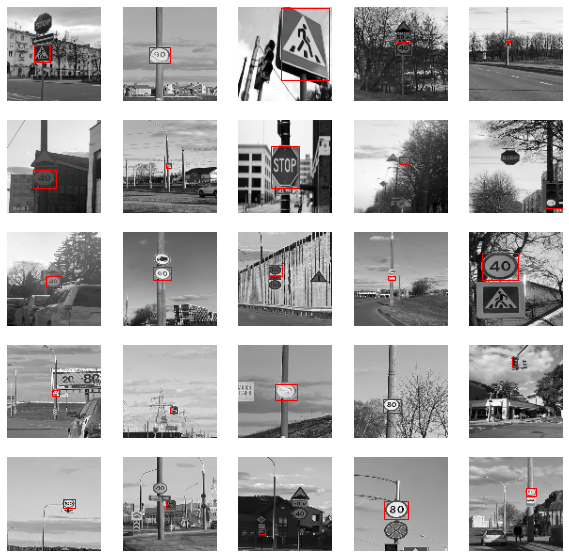

In [48]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(10,10)) 

for i in range(25):
    plt.subplot(5,5,i+1)   
    plt.imshow(x_train[i].reshape(100, 100), cmap = 'gray')
    [a,b,c,d] = y_train[i]
    plt.gca().add_patch(Rectangle((a,b),c-a,d-b,linewidth=1,edgecolor='r',facecolor='none'))
    plt.axis('off')
plt.show()
from matplotlib.patches import Rectangle


### data preprocessing

In [20]:
def preprocess_data(x, y, no_classes,limit=None):
    x = x[:limit]
    y = y[:limit]
    x = x.reshape(len(x), 1, 100, 100)/255
    y = y.astype("float32") / 100
    return x, y

no_classes = 4
x_train, y_train = preprocess_data(x_train, y_train, no_classes)
x_test, y_test = preprocess_data(x_test, y_test, no_classes)

### EXPERIMENTS

In [21]:
depth = 1
img_size = 100
kernel_size = 3
l1_size = img_size - kernel_size + 1
l2_size = l1_size - kernel_size + 1
l3_size = l2_size - kernel_size + 1
l4_size = l3_size - kernel_size + 1
no_class = 4

In [28]:
size = 200

for lr in [0.03]:

    print('learning rate: ', lr)
    network = [
        Convolutional((depth, img_size, img_size), kernel_size),
        # LkRelu(0.1),
        # Sigmoid(),
        Tanh(),
        # Maxpool((depth, l1_size, l1_size), kernel_size),
        Avgpool((depth, l1_size, l1_size), kernel_size),

        Convolutional((depth, l2_size, l2_size), kernel_size),
        # LkRelu(0.1),
        # Sigmoid(),
        Tanh(),
        # Maxpool((depth, l3_size, l3_size), kernel_size),
        Avgpool((depth, l3_size, l3_size), kernel_size),
        
        Reshape((depth, l4_size, l4_size), (depth * l4_size * l4_size, 1)),
        Dense(depth * l4_size * l4_size, no_class),
        Sigmoid()
        
    ]
    train(network, mse, mse_prime, x_train[:size], y_train[:size], epochs=20, learning_rate=lr)


    filename = '/content/drive/MyDrive/IISc/PRNN/blood_saved_models/000traffic_tanh_avg_' + str(lr) + '.sav'
    pickle.dump(network, open(filename, 'wb'))


learning rate:  0.03
1/20, error=0.30926376575465353
2/20, error=0.2654869290927395
3/20, error=0.25663279976023795
4/20, error=0.25449707962374385
5/20, error=0.2530684106064388
6/20, error=0.2523804167586629
7/20, error=0.25202901387198196
8/20, error=0.25225120201511564
9/20, error=0.25219061365247336
10/20, error=0.2521408718098568
11/20, error=0.25224835516173205
12/20, error=0.2521842646779216
13/20, error=0.25229481509710516
14/20, error=0.2522097510909153
15/20, error=0.2520293149371422
16/20, error=0.2519279985144697
17/20, error=0.25219924047403325
18/20, error=0.2520014121644425
19/20, error=0.2522036914069368
20/20, error=0.2521212007077706
<function mse at 0x7f32d29afe60> 0.03 [0.30926376575465353, 0.2654869290927395, 0.25663279976023795, 0.25449707962374385, 0.2530684106064388, 0.2523804167586629, 0.25202901387198196, 0.25225120201511564, 0.25219061365247336, 0.2521408718098568, 0.25224835516173205, 0.2521842646779216, 0.25229481509710516, 0.2522097510909153, 0.2520293149

In [30]:
def plot_error(lkrelu, tan, sig, title_name):
    x = range(1, 21)
    
    plt.plot(x, lkrelu, label = "lkrelu")
    plt.plot(x, tan, label = "tan")
    plt.plot(x, sig, label = "sig")

    plt.xlabel('iteration')

    plt.ylabel('training error')
    plt.xticks(np.arange(0, 21, 5.0))
    plt.legend()

    plt.title(title_name)

    plt.show()



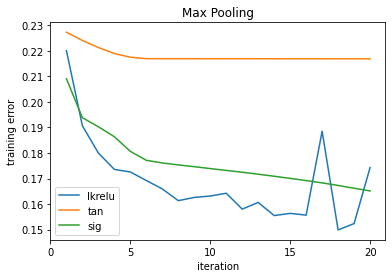

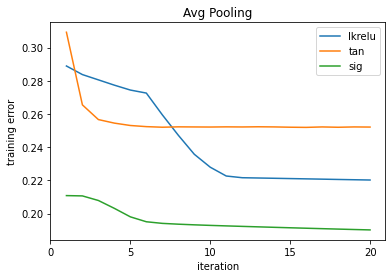

In [40]:
#max
t = [0.22726772399685224, 0.22405348501795735, 0.22127851690348582, 0.21892743595247158, 0.21749298974628925, 0.2169191304111825, 0.2169108411377668, 0.2169070152224806, 0.21690305699022186, 0.21689895073911258, 0.21689533382670095, 0.21689193227290332, 0.21688874983765452, 0.21688546458685726, 0.21688174624450698, 0.21687741520423234, 0.21687231646500835, 0.21686682213362152, 0.21686192370184318, 0.21685625051132326]
s = [0.20907429856140616, 0.19380420490332975, 0.19025522643569132, 0.18636188282993127, 0.1806261353722583, 0.17711684823663543, 0.17608741806899378, 0.1753247449827679, 0.17462660104933894, 0.1738890375705372, 0.1731622003710696, 0.17245500737112782, 0.17168229853265188, 0.17088087219787235, 0.1700442849202286, 0.1691900463586097, 0.16828529586574315, 0.16727613181139595, 0.16620764024032625, 0.16512769541822528]
l = [0.2200572732087415, 0.1906217479577332, 0.1799647639686173, 0.17356251970989006, 0.17255031541082133, 0.16921151358582534, 0.1659243237421249, 0.1613191817401431, 0.1625890761616415, 0.16313699880430632, 0.16423426595698892, 0.15801919557741262, 0.16063971966529533, 0.1554828793352927, 0.15634579058448939, 0.1556571882433062, 0.18849942401913547, 0.14986888113730168, 0.1523475512801231, 0.17428392568775963]

plot_error(l, t, s, 'Max Pooling')
#avg
t = [0.30926376575465353, 0.2654869290927395, 0.25663279976023795, 0.25449707962374385, 0.2530684106064388, 0.2523804167586629, 0.25202901387198196, 0.25225120201511564, 0.25219061365247336, 0.2521408718098568, 0.25224835516173205, 0.2521842646779216, 0.25229481509710516, 0.2522097510909153, 0.2520293149371422, 0.2519279985144697, 0.25219924047403325, 0.2520014121644425, 0.2522036914069368, 0.2521212007077706]
s = [0.21081635787467284, 0.21063674492147133, 0.20787199423558847, 0.20312905685163007, 0.198016222229582, 0.19505669510047588, 0.1940820174582625, 0.19359545827110708, 0.19320326545405694, 0.19286756499225644, 0.1925626583387928, 0.19227166434267873, 0.19198726104207772, 0.19170707254575137, 0.19143095236354984, 0.19115968649505008, 0.19089427584740337, 0.1906355327092827, 0.19038391372358895, 0.19013951679884158]
l = [0.2889241441522053, 0.2837475060741084, 0.28056619682294487, 0.2773687249762658, 0.27442466211130173, 0.27260347359587245, 0.2594982149867523, 0.24720167812311714, 0.23573774145152623, 0.22792377302493916, 0.22262697459331068, 0.22159565371353293, 0.22142705504350502, 0.2212565869471463, 0.22107941116419996, 0.2209081179563362, 0.2207288764941816, 0.22054817788255673, 0.22037776677603518, 0.22021185521275105]
plot_error(l, t, s, 'Avg Pooling')


In [32]:
def bb_intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)
	return np.abs(iou)

In [33]:
def getMetrics(y_pred, actual):
        
    MoU = 0
    for i in range(y_pred.shape[0]):
        MoU += bb_intersection_over_union(y_pred[i], actual[i])
        
    MSE = np.mean(0.5 * (actual - y_pred)**2)
    MAE = np.mean(np.abs(actual - y_pred))

    return MSE,MoU/y_pred.shape[0],MAE

In [51]:
import os
pth = '/content/drive/MyDrive/IISc/PRNN/traffic_data/best_models'
best_models = os.listdir(pth)
print(best_models)

op = []
for filename in best_models:
    model = pickle.load(open(pth + '/' + filename, 'rb'))
    op = []
    for x in x_test:
        op.append(predict(model, x))
    metr = getMetrics(np.array(op).reshape(264, 4)*100, y_test.reshape(264, 4)*100)
    print(metr)
    print(filename)
    



['000traffic_tanh_avg_0.03.sav', '000traffic_lk_avg_0.003.sav', '000traffic_tanh_max_0.003.sav', '000traffic_sig_avg_0.03.sav', '000traffic_lk_max_0.03.sav', '000traffic_sig_max_0.01.sav']
(1241.7159738275477, 0.00038640495580974637, 46.27084703071407)
000traffic_tanh_avg_0.03.sav
(1172.9883713289553, 0.00028655267625300594, 44.60838470560416)
000traffic_lk_avg_0.003.sav
(1147.3199849597938, 0.0004288348829363575, 44.40022400139582)
000traffic_tanh_max_0.003.sav
(1011.6476279502167, 0.0004396866461117314, 40.22326176149659)
000traffic_sig_avg_0.03.sav
(835.2832187937995, 0.02370237728234932, 35.8982970337677)
000traffic_lk_max_0.03.sav
(1126.6889735685259, 0.0004288348773779866, 43.998469566450076)
000traffic_sig_max_0.01.sav
